# Approximate Inference 

- In any sampling algorithm, the answers are computed by counting the actual samplesgenerated.

In [3]:
import numpy as np
import distrax
import jax
import jax.numpy as jnp

In [5]:
key = jax.random.PRNGKey(1234)
mu = jnp.array([-1., 0., 1.])
sigma = jnp.array([0.1, 0.2, 0.3])

dist_distrax = distrax.MultivariateNormalDiag(mu, sigma)

samples = dist_distrax.sample(seed=key)

# Both print 1.775
print(dist_distrax.log_prob(samples))

1.7750063


## Direct sampling 

First init the example problem: 

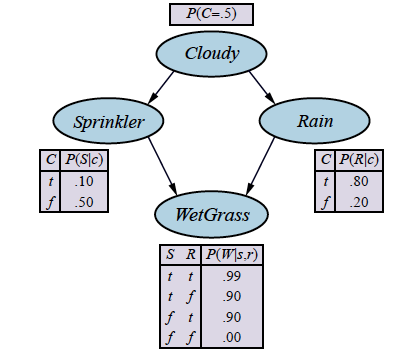

In [34]:
# cloudy
p_cloudy = np.array([0.5, 0.5])         # cloudy=0, cloud=1

# cloudy,sprinkler
p_sprinkler_given_cloudy = np.array(
    [
        np.array([0.5, 0.5]),           # sprinkler=0, sprinker=1 | cloudy=0. 
        np.array([0.9, 0.1])            # sprinkler=0, sprinker=1 | cloudy=1. 
    ]
)
# cloudy, rain
p_rain_given_cloudy = np.array(
    [
        np.array([0.8, 0.2]),           # rain=0, rain=1 | cloudy=0. 
        np.array([0.2, 0.8])            # rain=0, rain=1 | cloudy=1. 
    ]
)
# sprinkler, rain, wetgrass
p_wetgrass_given_sprinkler_and_rain = np.array(
    [
        np.array([ # sprinkler=0
            np.array([0, 1]), # rain=0
            np.array([0.1, 0.9]), # rain=1
        ]),   
        np.array([ # sprinkler=1
            np.array([0.1, 0.90]), # rain=0
            np.array([0.01, 0.99]), # rain=1
        ])
    ]
)
p_cloudy

array([0.5, 0.5])

Sampling is based on sampling from a known probability distribution. Therefore will write a 1d sampling function:

(array([205.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 795.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

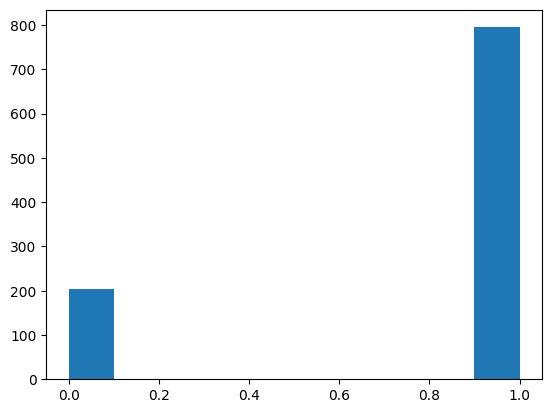

In [28]:
import matplotlib.pyplot as plt 

def inverse_transform_sample(x):
    assert len(x.shape) == 1
    assert np.sum(x) == 1
    F = np.cumsum(x)
    uniform_01 = np.random.uniform()
    for i,f in enumerate(F):
        if uniform_01 <= f:
            return i 

plt.hist([inverse_transform_sample(np.array([0.2,0.8])) for _ in range(1000)])

^ This show the sampling in action

Now to sample an event from the bays net. An event is a binary 4-vector for state. e.g. [cloudy, sprinkler, rain, wetgrass]

In [31]:
p_cloudy

array([0.5, 0. , 5. ])

In [41]:
def sample_bays_net():
    # sample parents then children 
    event_cloudy = inverse_transform_sample(p_cloudy)
    
    # sample cloudy children 
    event_sprinkler = inverse_transform_sample(p_sprinkler_given_cloudy[event_cloudy])
    event_rain = inverse_transform_sample(p_rain_given_cloudy[event_cloudy])

    # finally sample wet grass
    event_grass = inverse_transform_sample(p_wetgrass_given_sprinkler_and_rain[event_sprinkler, event_rain])

    return [event_cloudy, event_sprinkler, event_rain, event_grass]

for _ in range(5):
    print(sample_bays_net())
    

[0, 1, 0, 1]
[0, 0, 0, 1]
[0, 1, 0, 1]
[0, 1, 0, 1]
[0, 0, 0, 1]


^ Direct sampling method and 5 samples,

Now to get a joint we sample, and count each configuration. The joint is a 2x2x2x2 tensor. 

(cloudy, sprinkler, rain, wetground)

In [47]:
n_samples = 5000
samples = np.stack([sample_bays_net() for _ in range(n_samples)])
samples.shape

(5000, 4)

In [54]:
joint.shape

(2, 2, 2, 2)

In [57]:
joint = np.zeros((2,2,2,2))
for sample in samples:
    joint[tuple(sample)] += 1

In [60]:
np.sum(joint / n_samples)

1.0

Boom a joint.

## Rejection sampling 

- Direct sampling for computing a *conditional probability*.

- $p(event | evidence )$

Previously direct sampling was used to get the joint distribution (and so the prob of any event). 

(Of course we could marginalise the joint)

In [63]:
def rejection_sample(evidence_cloud=None, evidence_sprinkler=None, evidence_rain=None, evidence_wetground=None):
    event = sample_bays_net()
    for i, evidence in enumerate([evidence_cloud, evidence_sprinkler, evidence_rain, evidence_wetground]):
        if evidence != None: 
            if event[i] != evidence:
                return False
    return event 


for _ in range(5):
    print(rejection_sample(evidence_cloud=1))
    

False
False
[1, 0, 1, 0]
[1, 0, 1, 1]
False


THis function returns False for a rejected sample and the event for an accepted sample (evidence matches the event sample). This can then construct the joint which has gaurnteed evidence 



In [82]:
# calculate p(rain | sprinkler = true )
results = []
for _ in range(10000):
    event = rejection_sample(evidence_sprinkler=True)
    if event:
        results.append(event)
results = np.stack(results)
results.shape

(2975, 4)

In [83]:
# sum true divide by num non rejected 
p_rain_given_sprinkler_true = np.sum(results, axis=0)[3] / results.shape[0]
p_not_rain_given_sprinkler_true = 1 - (p_rain_given_sprinkler_true)
p_not_rain_given_sprinkler_true, p_rain_given_sprinkler_true

(0.06957983193277306, 0.9304201680672269)

Main issue of rejection sampling is rare events. We may reject 10000x the samples we accept. 

This takes us to 

## Importance sampling 

Idea: sample from P using samples from Q with correction 


In [67]:
def evidence_sample_bays_net(evidence_cloud=None, evidence_sprinkler=None, evidence_rain=None, evidence_wetground=None):
    # sample parents then children 
    if evidence_cloud == None:
        event_cloudy = inverse_transform_sample(p_cloudy)
    else:
        event_cloudy = evidence_cloud

    if evidence_sprinkler == None:
        event_sprinkler = inverse_transform_sample(p_sprinkler_given_cloudy[event_cloudy])
    else:
        event_sprinkler = evidence_sprinkler

    if evidence_rain == None:
        event_rain = inverse_transform_sample(p_rain_given_cloudy[event_cloudy])
    else:
        event_rain = evidence_rain
    
    if evidence_wetground == None:
        event_grass = inverse_transform_sample(p_wetgrass_given_sprinkler_and_rain[event_sprinkler, event_rain])
    else:
        event_grass = evidence_wetground

    return [event_cloudy, event_sprinkler, event_rain, event_grass]

for _ in range(5):
    print(evidence_sample_bays_net(evidence_cloud=0, evidence_rain=1))
    

[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 1, 1, 1]
[0, 0, 1, 1]
[0, 1, 1, 1]


^ Every sample is consistent with the evidence. BUT this sampling disturbition is Q not P. For example if all variables were True (as evidence) this algorithm would give the event (1,1,1,1) 100% probability weighting. 

We need to add a weighting on the sample. how likely is it?

Idea: for evidence variables compute prob based on sample, liklihood is product of these guys. 

Liklihood 

In [94]:
def weighted_sample(evidence_cloud=None, evidence_sprinkler=None, evidence_rain=None, evidence_wetground=None):
    # sample parents then children 
    weight = 1
    if evidence_cloud == None:
        event_cloudy = inverse_transform_sample(p_cloudy)
    else:
        event_cloudy = evidence_cloud
        weight = weight * p_cloudy[evidence_cloud]
    if evidence_sprinkler == None:
        event_sprinkler = inverse_transform_sample(p_sprinkler_given_cloudy[event_cloudy])
    else:
        event_sprinkler = evidence_sprinkler
        weight = weight * p_sprinkler_given_cloudy[event_cloudy][evidence_sprinkler]
    if evidence_rain == None:
        event_rain = inverse_transform_sample(p_rain_given_cloudy[event_cloudy])
    else:
        event_rain = evidence_rain
        weight = weight * p_rain_given_cloudy[event_cloudy][evidence_rain]
    if evidence_wetground == None:
        event_grass = inverse_transform_sample(p_wetgrass_given_sprinkler_and_rain[event_sprinkler, event_rain])
    else:
        event_grass = evidence_wetground
        weight = weight * p_wetgrass_given_sprinkler_and_rain[event_sprinkler, event_rain][event_grass]
    return np.array([event_cloudy, event_sprinkler, event_rain, event_grass]) * weight

def likelihood_weighting(evidence_cloud=None, evidence_sprinkler=None, evidence_rain=None, evidence_wetground=None, n_samples=5000):
    W = np.zeros(4)
    for _ in range(n_samples):
        W = W + weighted_sample(evidence_cloud, evidence_sprinkler, evidence_rain, evidence_wetground)
    W_of_interest = W[np.array([evidence_cloud, evidence_sprinkler, evidence_rain, evidence_wetground]) == None]
    return W_of_interest / n_samples

likelihood_weighting(evidence_cloud=0, evidence_rain=1)
    

array([0.04938, 0.09434])

^ p_sprinkler, p_wetground | cloud=1, rain=1

TODO: not sure on this 

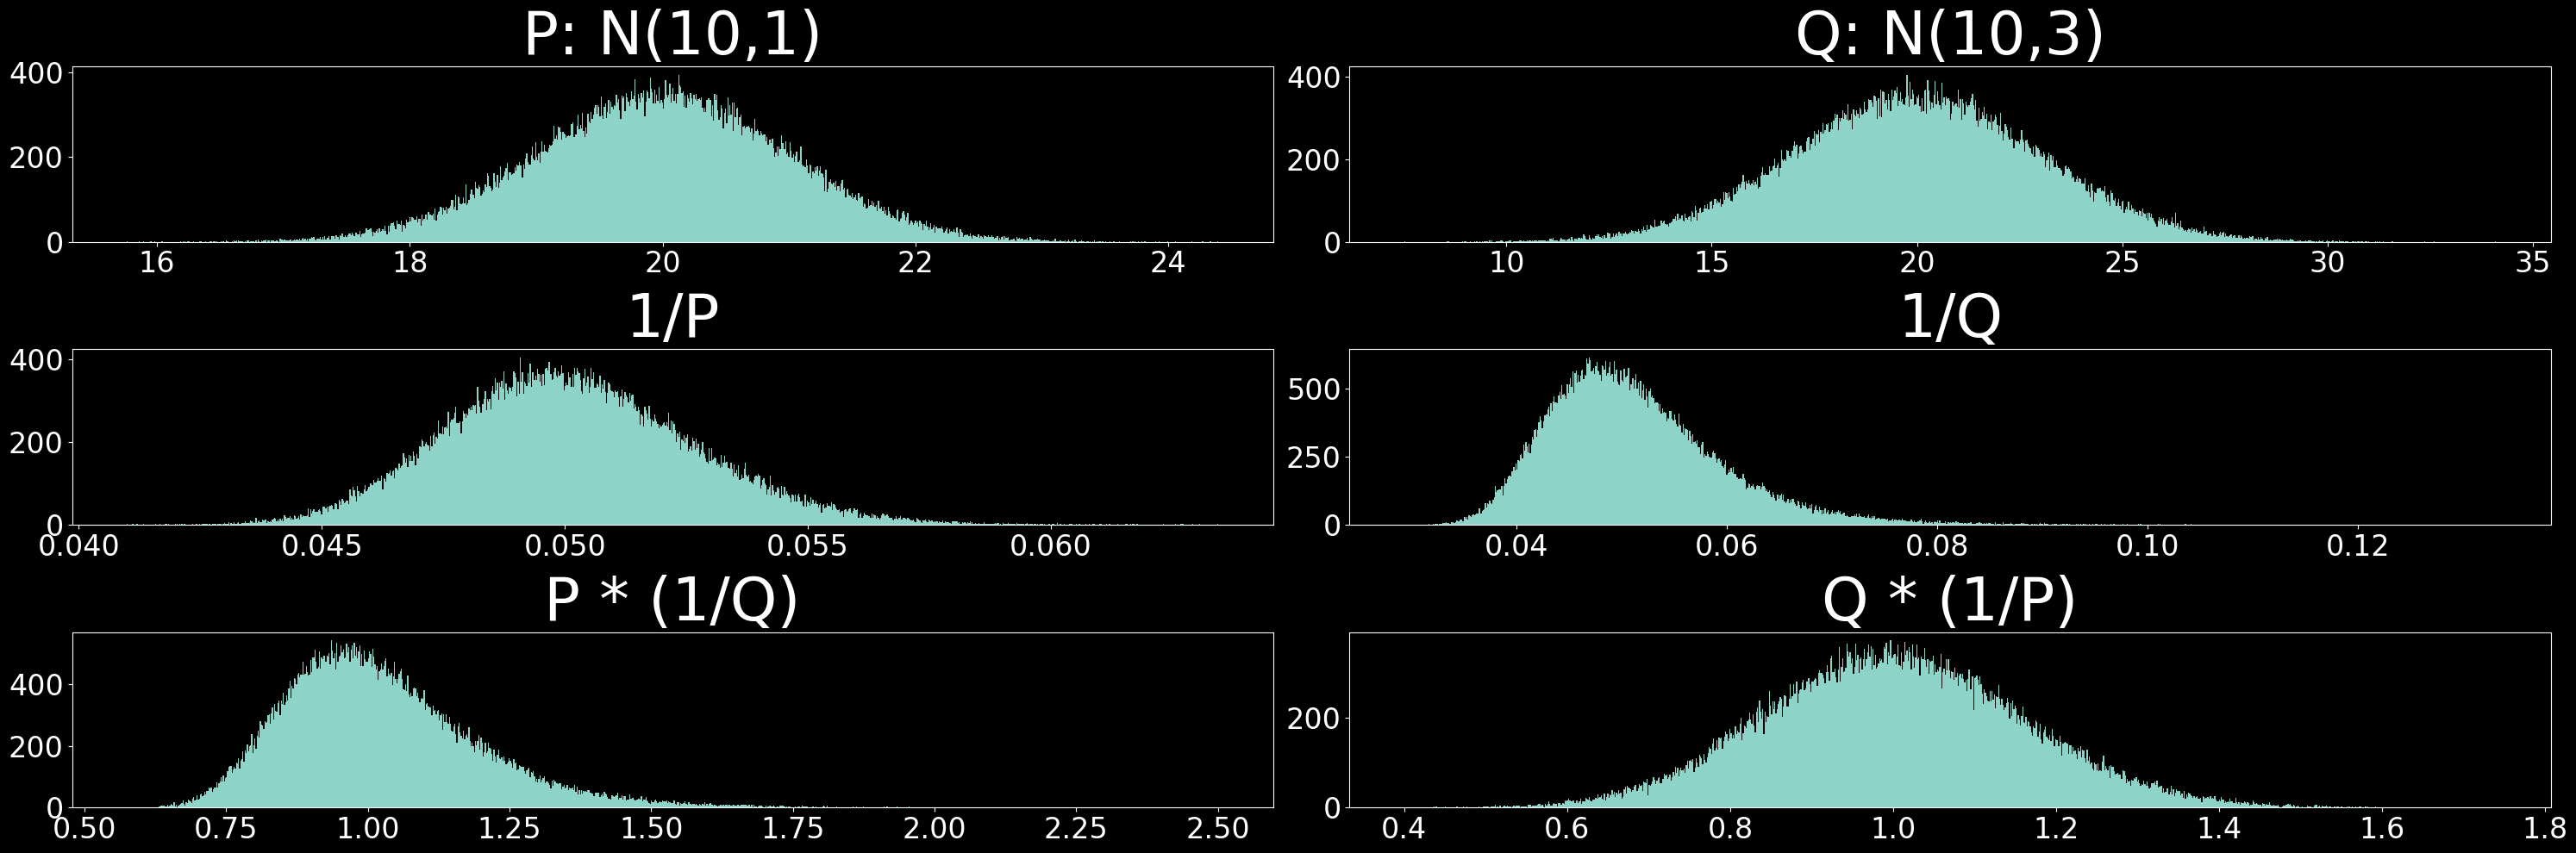

In [137]:
# quick look at ratio distrubtion 
plt.style.use('dark_background')
P = np.random.normal(20,1,100000)
Q = np.random.normal(20,3,100000)
fig, axs = plt.subplots(3,2,figsize=(30,10))
axs[0,0].hist(P, bins=1000)
axs[0,0].set_title('P: N(10,1)', fontsize=50)
axs[0,0].tick_params(axis='both', which='major', labelsize=24)
axs[0,1].hist(Q, bins=1000)
axs[0,1].set_title('Q: N(10,3)', fontsize=50)
axs[0,1].tick_params(axis='both', which='major', labelsize=24)
axs[1,0].hist(1 / P, bins=1000)
axs[1,0].set_title('1/P', fontsize=50)
axs[1,0].tick_params(axis='both', which='major', labelsize=24)
axs[1,1].hist(1 / Q, bins=1000)
axs[1,1].set_title('1/Q', fontsize=50)
axs[1,1].tick_params(axis='both', which='major', labelsize=24)

axs[2,0].hist(P * (1/Q), bins=1000)
axs[2,0].set_title('P * (1/Q)', fontsize=50)
axs[2,0].tick_params(axis='both', which='major', labelsize=24)
    
axs[2,1].hist(Q * (1/P), bins=1000)
axs[2,1].set_title('Q * (1/P)', fontsize=50)
axs[2,1].tick_params(axis='both', which='major', labelsize=24)

plt.tight_layout()

## MCMC

Idea: instead of random sample, peturb previous sample 

- Gibbs
- Metropolis Hastings

Markov chain refers to a random process that generates a sequence of states.

TODO: comparioson with not bayes net models 

### Gibbs sampling 

Idea : flick one state at a a time 

Pseudo: 
(1) fix evidence variables, random init other variables 
(2) sample (w markov blanket) nonevidence variables according to $\rho$
(3) 

markov blanket = parents, children, childrens parents 

# Hamiltonian Monte Carlo 
see : A Conceptual Introduction toHamiltonian Monte CarloMichael Betancourt